# Brain Tumor Detection
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [1]:
from tqdm.notebook import tqdm
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU'), tf.__version__

2025-02-14 13:24:26.124742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739539466.136655   70826 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739539466.140295   70826 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-14 13:24:26.153421: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [2]:
from utils.visualization_funcs import plot_random_images_bbox
from utils.prepare_dataset import PrepareDataset

In [3]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [4]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/brain-tumor-2/train/


In [5]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [6]:
DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)

TRAIN_IMAGE_DIR = TRAIN_DIR / 'images'
TRAIN_LABELS_DIR = TRAIN_DIR / 'labels'

VALID_IMAGE_DIR = VALIDATION_DIR / 'images'
VALID_LABELS_DIR = VALIDATION_DIR / 'labels'

TEST_IMAGE = TEST_DIR / 'images'
TEST_LABELS = TEST_DIR / 'labels'

IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE

CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {k: v for k, v in enumerate(CLASS_NAME)}

NUM_CLASSES = len(CLASS_NAME)

## Dataset Download from Roboflow

In [7]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow()
    project = rf.workspace("roboflow-100").project("brain-tumor-m2pbp")
    version = project.version(2)
    dataset = version.download("yolov8")        

## Load images from directory

In [8]:

prepare_train_dataset = PrepareDataset(image_dir=TRAIN_IMAGE_DIR, 
                                    label_dir=TRAIN_LABELS_DIR,
                                    dst_img_size=(IMG_SIZE, IMG_SIZE))

train_images, train_class_ids, train_bboxes  = prepare_train_dataset.get_dataset()

  0%|          | 0/6930 [00:00<?, ?it/s]

In [9]:
len(train_images), len(train_class_ids), len(train_bboxes)

(15296, 15296, 15296)

Random samples: [6031, 3361, 9194, 2901, 917, 3220, 1975, 3707, 13648]


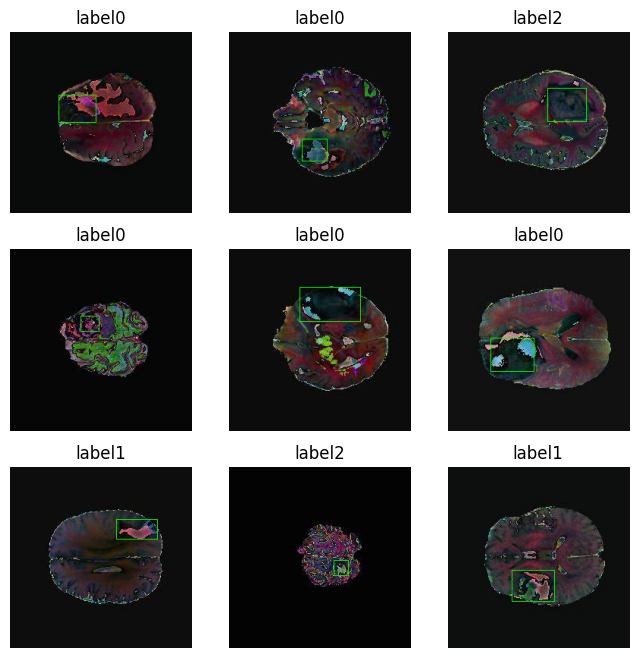

In [10]:
plot_random_images_bbox(image_paths=train_images, 
                        class_ids=train_class_ids, 
                        bboxes=train_bboxes,
                        class_map=class_map)

## Rebalance dataset by Down sempling to dataset with min images

In [11]:
rebal_train_images, rebal_train_class_ids, rebal_train_bboxes = prepare_train_dataset.rebalance_by_down_sampling_datasets()
len(train_images), len(train_class_ids), len(train_bboxes)

[INFO] Unique class ids: [0 1 2], value counts: [4338 6836 4122]


(15296, 15296, 15296)

Random samples: [952, 990, 4138, 6097, 8440, 6312, 11186, 10884, 7581]


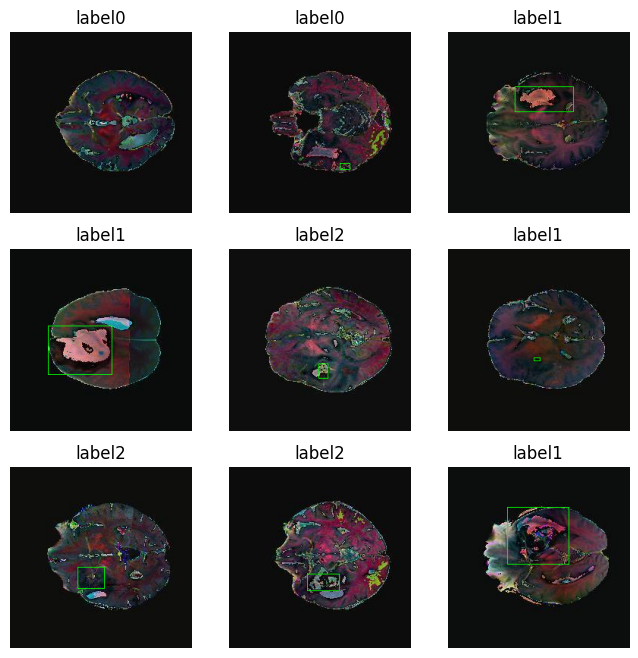

In [12]:
plot_random_images_bbox(image_paths=rebal_train_images,
                        class_ids=rebal_train_class_ids,
                        bboxes=rebal_train_bboxes,
                        class_map=class_map)

In [13]:
train_datasets = tf.data.Dataset.from_tensor_slices(
    (rebal_train_images, rebal_train_class_ids, rebal_train_bboxes))


I0000 00:00:1739539471.682677   70826 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7045 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [14]:
len(train_datasets)

12366

In [15]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset( image_path, classes, bbox):
    images = load_image(image_path)
    return   tf.cast(images, tf.float32), (tf.one_hot(classes,NUM_CLASSES), bbox)

In [16]:
train_ds = train_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE) 
train_ds = train_ds.shuffle(BATCH_SIZE * 4, reshuffle_each_iteration=True)\
                                .repeat()\
                                .batch(BATCH_SIZE, drop_remainder=True)\
                                .prefetch(tf.data.AUTOTUNE)



### Validation datasets setup

In [17]:
prepare_valid_datasets = PrepareDataset(image_dir=VALID_IMAGE_DIR,
                                label_dir=VALID_LABELS_DIR)
valid_image_paths, valid_class_ids, valid_bboxes = prepare_valid_datasets.get_dataset()
len(valid_image_paths), len(valid_class_ids), len(valid_bboxes)

  0%|          | 0/1980 [00:00<?, ?it/s]

(4442, 4442, 4442)

In [18]:
val_datasets = tf.data.Dataset.from_tensor_slices((valid_image_paths,
                                               valid_class_ids,
                                               valid_bboxes))

val_ds = val_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.repeat()\
                .batch(BATCH_SIZE, drop_remainder=True)\
                .prefetch(tf.data.AUTOTUNE)

### Testing Datasets setup

In [19]:
TEST_IMAGE = TEST_DIR/'images'
TEST_LABELS = TEST_DIR/'labels'

prepare_test_datasets = PrepareDataset(image_dir=TEST_IMAGE,
                                label_dir=TEST_LABELS)
test_image_paths, test_class_ids, test_bboxes = prepare_test_datasets.get_dataset()
len(test_image_paths), len(test_class_ids), len(test_bboxes)

  0%|          | 0/990 [00:00<?, ?it/s]

(2150, 2150, 2150)

In [20]:
test_datasets = tf.data.Dataset.from_tensor_slices((test_image_paths,
                                               test_class_ids,
                                               test_bboxes))

test_ds = test_datasets.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.repeat()\
                .batch(BATCH_SIZE, drop_remainder=True)\
                .prefetch(tf.data.AUTOTUNE)

## Define DenseNet121 Model

In [37]:
### Define DenseNet121 as a Feature Extractor
def feature_extractor(inputs)-> tf.keras.Model:
    inputs = tf.keras.applications.densenet.preprocess_input(inputs)
    # Create a DenseNet121 model object
    densenet121 = tf.keras.applications.DenseNet121(
        include_top = False, 
        weights = "imagenet",
        input_shape = (IMG_SIZE, IMG_SIZE, 3),
        input_tensor=inputs
    )
    
    densenet121.trainable = False
    for layer in densenet121.layers[:149]:
        layer.trainable = False
    for layer in densenet121.layers[149:]:
        layer.trainable = True
        
    feature_extractor = densenet121.output
    return feature_extractor


### Define Dense Layers
def dense_layers(features)->tf.keras.Layer:
    l2 = tf.keras.regularizers.l2

    x = tf.keras.layers.GlobalAveragePooling2D()(features)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(units=1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(units=512, activation='relu',  kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    return x

### Define Bounding Box Regression
def bounding_box_regression(x)->tf.keras.Layer:

    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(units=4, name='bounding_box')(x)

    return bounding_box_regression_output

###Define Classifier Layer
def classifer(inputs)->tf.keras.Model:
    return tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax',  name = 'classification')(inputs)

### Final Model

In [38]:
def mobv2_feature_extractor(inputs):
    
    inputs = tf.keras.applications.mobilenet.preprocess_input(inputs)

    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )

    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)

    # return the feature_extractor
    return feature_extractor#.outputs

In [39]:
def final_model()->tf.keras.Model:
    
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    _feature_extractor = feature_extractor(inputs)
    # _feature_extractor = mobv2_feature_extractor(inputs)
    
    dense_output = dense_layers(_feature_extractor)

    bounding_box_regression_output = bounding_box_regression(dense_output)

    classification_output = classifer(dense_output)

    return tf.keras.Model(inputs=inputs, 
                          outputs=[classification_output, bounding_box_regression_output])

### Define  Callbacks

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=2,
                                                  restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_classification_accuracy', 
                                                 factor=0.2, 
                                                 patience=2, 
                                                 verbose=1, 
                                                 mode='auto', 
                                                 min_delta=0.0001, 
                                                 cooldown=0, 
                                                 min_lr=0.001)
model_checkpoint =  tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),

### Define Optimizer

In [41]:
LEARNING_RATE = 1e-4

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, use_ema=True)

## Model Building and Compilation

In [42]:
# tf.keras.backend.clear_session()

In [43]:
densenet121_model = final_model()

In [44]:
densenet121_model.compile(
    optimizer=optimizer,
    loss={'classification': 'categorical_crossentropy', 'bounding_box': 'mse'},
    metrics={'classification': 'accuracy', 'bounding_box': 'mse'})

In [45]:
# densenet121_model.summary()

## Train and Validate the model

In [46]:
EPOCHS = 50

In [47]:
import math
# Get the length of the training set
length_of_training_dataset = len(train_datasets)

# Get the length of the validation set
length_of_validation_dataset = len(val_datasets)

# Get the steps per epoch (may be a few lines of code)
steps_per_epoch = math.ceil(length_of_training_dataset/BATCH_SIZE)

# get the validation steps (per epoch) (may be a few lines of code)
validation_steps = math.ceil(length_of_validation_dataset/BATCH_SIZE)
validation_steps


278

In [ ]:
history = densenet121_model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
)

Epoch 1/50


### Model Evaluation

In [ ]:
loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = densenet121_model.evaluate(test_ds, steps=1)
print("Validation accuracy: ", classification_accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - bounding_box_loss: 0.0140 - bounding_box_mse: 0.0140 - classification_accuracy: 0.1875 - classification_loss: 7.1145 - loss: 7.1481
Validation accuracy:  0.014000924304127693


In [ ]:
def plot_metrics(metric_name, title, ylim=1):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.xlabel("Epochs")
  plt.legend([metric_name, 'val_' + metric_name])
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

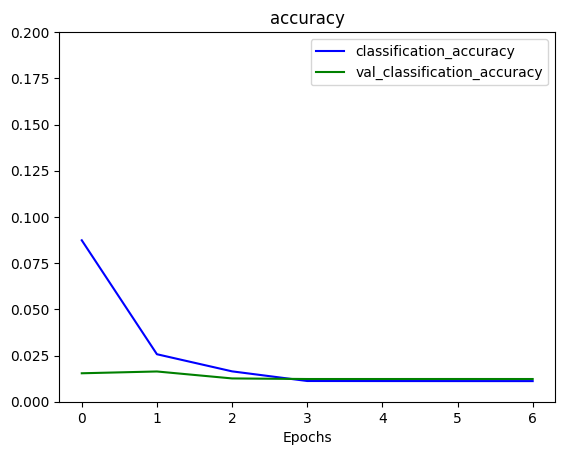

In [ ]:
plot_metrics("bounding_box_loss", "bounding_box_loss", ylim=0.2)
plot_metrics("classification_accuracy", "accuracy", ylim=0.2)

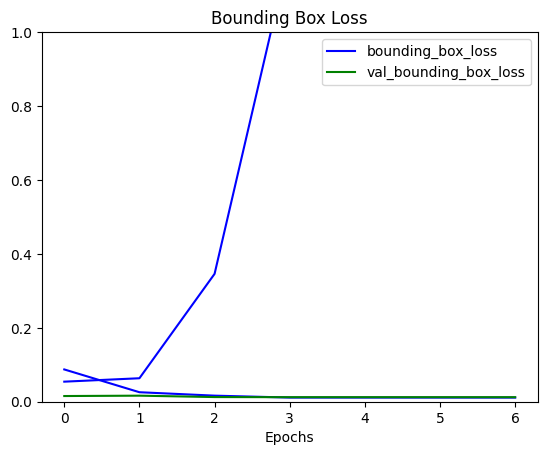

In [ ]:
plot_metrics("classification_loss", "Classification Loss")
plot_metrics("bounding_box_loss", "Bounding Box Loss")